In [1]:
import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 8
batch_size=2
input_dim = 512
d_model = 512
x = torch.randn(batch_size, sequence_length, input_dim)

In [3]:
x.size()

torch.Size([2, 8, 512])

In [4]:
x

tensor([[[-1.3180e+00, -3.2235e-01, -1.5186e+00,  ...,  3.5957e-04,
          -1.9589e+00,  4.8123e-01],
         [ 1.7617e+00,  7.7007e-03,  2.5249e-02,  ...,  8.3397e-01,
          -9.6481e-01, -9.2821e-01],
         [ 1.4077e+00, -5.9958e-01,  8.0367e-02,  ..., -1.7613e+00,
           1.5038e-02, -2.2514e-01],
         ...,
         [ 8.2077e-01,  7.2577e-01, -2.3880e+00,  ..., -1.1423e+00,
           6.0449e-01,  8.6482e-02],
         [ 1.8066e-01,  7.1664e-02,  6.1804e-01,  ...,  3.9780e-01,
          -2.4030e-01,  1.0186e+00],
         [-1.2977e+00, -4.3615e-01,  3.9070e-01,  ...,  1.2453e+00,
          -4.9179e-01,  2.8126e-01]],

        [[-4.5732e-01,  9.6223e-01, -4.6166e-01,  ...,  2.4915e-01,
           1.3186e+00, -1.7557e+00],
         [ 4.9646e-02,  1.9625e-01,  1.4720e+00,  ..., -1.7075e+00,
           2.7126e-01,  8.0068e-01],
         [-9.8098e-01,  2.5349e-01,  1.5043e+00,  ...,  9.4976e-01,
          -1.8435e+00,  7.9616e-01],
         ...,
         [-9.2094e-01,  6

In [5]:
qkv = nn.Linear(input_dim, 3*d_model)

In [6]:
qkv = qkv(x)

In [7]:
qkv.size()

torch.Size([2, 8, 1536])

Text(0.5, 1.0, 'qkv distribution')

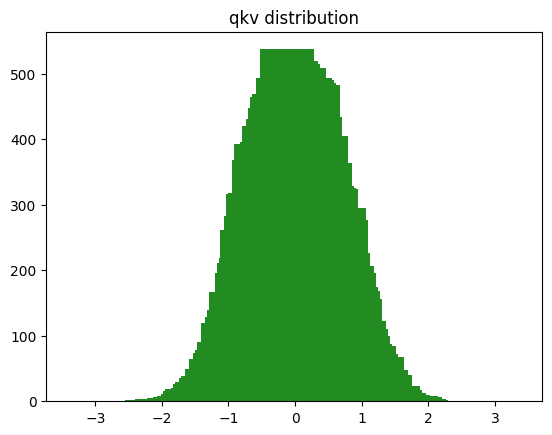

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01)*3
plt.bar(x_val, y_val, align='center', color='forestgreen')
plt.title('qkv distribution')

In [9]:
nums_head = 8
head_dim = d_model // nums_head
qkv = qkv.reshape(batch_size, sequence_length, nums_head, 3*head_dim)

In [10]:
qkv.shape

torch.Size([2, 8, 8, 192])

In [11]:
qkv.permute(0, 2, 1, 3) #batchsize, nums_head, sequence_length, 3*head_dim
qkv.shape

torch.Size([2, 8, 8, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([2, 8, 8, 64]),
 torch.Size([2, 8, 8, 64]),
 torch.Size([2, 8, 8, 64]))

In [13]:
dk = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(dk)
scaled.shape

torch.Size([2, 8, 8, 8])

In [14]:
k.T.shape

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6212\3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  k.T.shape


torch.Size([64, 8, 8, 2])

In [15]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
(scaled + mask)[0][0]

tensor([[-6.4553e-01,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [ 1.6439e-01, -8.9368e-02,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [ 2.4204e-01,  9.6823e-03, -5.9521e-01,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [-6.4056e-01, -7.0151e-01, -2.9663e-01, -2.6112e-01,        -inf,
                -inf,        -inf,        -inf],
        [-2.5240e-01,  1.3881e-01, -7.0492e-01, -1.9877e-01, -2.7607e-02,
                -inf,        -inf,        -inf],
        [ 8.7582e-01, -3.6660e-01, -3.7445e-01,  1.2254e-01,  9.7166e-02,
         -2.7331e-01,        -inf,        -inf],
        [ 3.0832e-01,  4.0796e-01, -2.6627e-01, -3.3140e-05,  2.6347e-02,
          1.0838e-01,  6.9217e-02,        -inf],
        [ 8.0213e-01, -3.3212e-01, -8.7427e-01,  8.5008e-01, -8.6817e-01,
          2.3254e-01,  1.0150e-01, -9.4729e-01]], grad_fn=<Select

In [17]:
scaled +=mask

In [18]:
attention = F.softmax(scaled, dim=-1)
attention.shape

torch.Size([2, 8, 8, 8])

In [19]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5631, 0.4369, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4493, 0.3562, 0.1945, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2078, 0.1955, 0.2931, 0.3037, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1844, 0.2727, 0.1173, 0.1946, 0.2309, 0.0000, 0.0000, 0.0000],
        [0.3544, 0.1023, 0.1015, 0.1668, 0.1627, 0.1123, 0.0000, 0.0000],
        [0.1735, 0.1917, 0.0977, 0.1275, 0.1309, 0.1421, 0.1366, 0.0000],
        [0.2511, 0.0808, 0.0470, 0.2635, 0.0473, 0.1421, 0.1246, 0.0437]],
       grad_fn=<SelectBackward0>)

In [20]:
values = torch.matmul(attention, v)
values.shape

torch.Size([2, 8, 8, 64])

In [21]:
import math
def scaled_dot_product(q,k,v, mask=None):
    dk = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1,-2))/math.sqrt(dk)
    if mask is not None:
        scaled += mask
        attention = F.softmax(scaled, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention

In [22]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [23]:
attention.shape

torch.Size([2, 8, 8, 8])

In [24]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5631, 0.4369, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4493, 0.3562, 0.1945, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2078, 0.1955, 0.2931, 0.3037, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1844, 0.2727, 0.1173, 0.1946, 0.2309, 0.0000, 0.0000, 0.0000],
        [0.3544, 0.1023, 0.1015, 0.1668, 0.1627, 0.1123, 0.0000, 0.0000],
        [0.1735, 0.1917, 0.0977, 0.1275, 0.1309, 0.1421, 0.1366, 0.0000],
        [0.2511, 0.0808, 0.0470, 0.2635, 0.0473, 0.1421, 0.1246, 0.0437]],
       grad_fn=<SelectBackward0>)

In [25]:
values.size()

torch.Size([2, 8, 8, 64])

In [26]:
values = values.reshape(batch_size, sequence_length, nums_head*head_dim)
values.size()

torch.Size([2, 8, 512])

In [27]:
linear_layer = nn.Linear(d_model, d_model)

In [28]:
out = linear_layer(values)

In [29]:
out.shape

torch.Size([2, 8, 512])

In [30]:
def scaled_dot_product(q, k, v, mask=None):
    dk = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(dk)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)  # 3 * d_model for q, k, v
        self.linear_layer = nn.Linear(d_model, d_model)  # Output transformation

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)   # Apply the qkv linear transformation
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)          # Reshape into (batch_size, sequence_length, num_heads, 3 * head_dim)
        print(f"qkv reshaped: {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3) # Permute to (batch_size, num_heads, sequence_length, 3 * head_dim
        print(f"qkv permuted: {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1) 
        print(f"q.size(): {q.size()}, k.size(): {k.size()}, v.size(): {v.size()}") # Split into q, k, v tensor
        values, attention = scaled_dot_product(q, k, v, mask) # Compute attention
        print(f"values.size(): {values.size()}, attention.size(): {attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # Reshape the values to (batch_size, sequence_length, d_model)
        print(f"values reshaped: {values.size()}")
        out = self.linear_layer(values) # Apply final linear transformation
        print(f"out.size(): {out.size()}")
        return out

In [31]:
input_dim = 1024
d_model=512
nums_head= 8
batch_size=30
sequence_length= 5
x = torch.rand((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, nums_head)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv reshaped: torch.Size([30, 5, 8, 192])
qkv permuted: torch.Size([30, 8, 5, 192])
q.size(): torch.Size([30, 8, 5, 64]), k.size(): torch.Size([30, 8, 5, 64]), v.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size(): torch.Size([30, 8, 5, 5])
values reshaped: torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
